In [1]:
from splink import DuckDBAPI
import pandas as pd
from splink.exploratory import completeness_chart, profile_columns
import phonenumbers
from pathlib import Path
import os
from tqdm import tqdm

In [2]:

RAW_DATA_DIR = Path("../") / 'data' / 'raw'

os.curdir, RAW_DATA_DIR

('.', PosixPath('../data/raw'))

In [ ]:
df2 = pd.read_csv(RAW_DATA_DIR / "main2.csv")

In [ ]:
completeness_chart(df2, db_api)

In [ ]:
profile_columns(table_or_tables=df2, db_api=db_api, top_n=10, bottom_n=5)

In [ ]:
df3 = pd.read_csv(RAW_DATA_DIR / "main3.csv")

In [ ]:
completeness_chart(df3, db_api)

In [ ]:
profile_columns(table_or_tables=df3, db_api=db_api, top_n=10, bottom_n=5)

# Data processing and visualization

converts data to a single format

first_name, last_name, middle_name, email, sex, dob, phone

In [ ]:
df2.head()

In [ ]:
df3.head()

## first data source preprocessing

In [3]:
df1 = pd.read_csv(RAW_DATA_DIR / "main1.csv")

In [4]:
db_api = DuckDBAPI()
completeness_chart(df1, db_api)

alt.LayerChart(...)

In [5]:
profile_columns(table_or_tables=df1, db_api=db_api, top_n=10, bottom_n=5)

alt.VConcatChart(...)

In [6]:
df1.head()

,uid,full_name,email,address,sex,birthdate,phone
0,8357db00-b4ce-4c33-a66e-1842744d0ce4,БАЛКИБАЕВ Углы МАМАСАИД КАРЛИТО,mamasaid_balkibaev0@example.ru,"г. Урус-Мартан, пер. Шмидта, д. 233 к. 6/4, 63...",m,1954-06-15,8 (020) 645-0526
1,a40182ff-7b3c-4fe4-9455-505414bf6f1c,ИГИНОВА ЮТТА КОНДРАТЬЕВНП,jutta_iginova1@yandex.ru,"бул. Есенина, д. 2/3 стр. 180, 881977",f,1981-11-24,8 (197) 128-63-27
2,2b401a4a-33c0-47e0-b527-300e17b3a8da,МИРОДИЛОВ ЗАФЕР РОБЕРТ,zafer_mirodilov2@mail.ru,"ст. Красногорск (Моск.), ул. Урожайная, д. 4/9...",m,1954-07-03,+7 585 762 7855
3,a844b52d-6fc8-4aac-9180-092cf3cba7b0,5МИРОДИЛОВ ЗАФЕР РОБЕРТ,zafer_mirodilov2mail,"ст. Красногорск (Моск.), ул. Урожайная, д. 4/9...",m,954-01-01,+7 (585) 762 7855
4,95b72c05-1620-4f55-b3d4-c5151ff83184,БОРОВАЯ ШАХЗОДА НИКОЛАЕВНА,shahzoda_borovaja3@gmail.com,"к. Устюжна, ш. Инженерное, д. 1/7 к. 4, 782855",f,1989-07-15,+7 017 511 8662


In [7]:
def parse_phone(phone: str) -> str | None:
    try:
        return phonenumbers.format_number(
            phonenumbers.parse(phone, "RU"), phonenumbers.PhoneNumberFormat.INTERNATIONAL
        )
    except phonenumbers.phonenumberutil.NumberParseException:
        return None

In [ ]:
def parse_full_name(full_name: str) -> tuple[str, str, str]:
    parts = full_name.lower().split()
    parts = [
        ''.join(char for char in part if char in 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя' or not char.isalpha())
        for part in parts
    ]
    return parts[0], parts[1] if len(parts) > 1 else "", parts[2] if len(parts) > 2 else ""

In [8]:

phones = df1["phone"]

invalid_values = []
for phone in tqdm(phones):
    parsed = parse_phone(phone)
    if parsed is None:
        invalid_values.append(phone)

100%|██████████| 8639816/8639816 [02:03<00:00, 70068.83it/s]


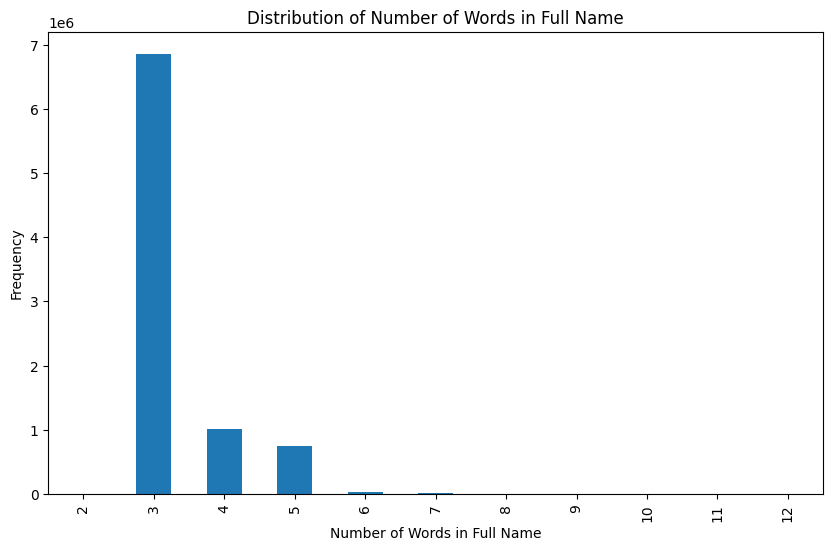

In [11]:
import matplotlib.pyplot as plt

# Calculate the number of words in the "full_name" column
df1['name_word_count'] = df1['full_name'].apply(lambda x: len(x.split()))

# Plot the distribution of the number of words in the "full_name" column
plt.figure(figsize=(10, 6))
df1['name_word_count'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Number of Words in Full Name')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Words in Full Name')
plt.show()

In [12]:
# Filter the rows where the number of words in the "full_name" column is greater than 3
full_names_with_more_than_3_words = df1[df1['name_word_count'] > 3]['full_name']

# Save these values to a text file
full_names_with_more_than_3_words.to_csv("full_names_with_more_than_3_words.txt", index=False, header=False)

In [9]:
print(f"Invalid phone numbers: {len(invalid_values)} / {len(phones)} ({len(invalid_values) / len(phones) * 100:.2f}%)")
with open("invalid_phones.txt", "w") as f:
    f.write("\n".join(invalid_values))

Invalid phone numbers: 73657 / 8639816 (0.85%)


In [35]:
def preprocess_type_1(df):
    df[['first_name', 'middle_name', 'last_name']] = df['full_name'].str.split(' ', expand=True, n=2)
    df.drop(columns=['full_name'], inplace=True)
    df1["phone"] = df1["phone"].apply(parse_phone)
    # rename column uid to unique_id
    df.rename(columns={"uid": "unique_id"}, inplace=True)
    return df

In [13]:
from splink import comparison_library, block_on

settings = {

}

In [36]:
test_df = df1.copy()
test_df = preprocess_type_1(test_df)

In [17]:
test_df.columns

Index(['uid', 'email', 'address', 'sex', 'birthdate', 'phone',
       'name_word_count', 'first_name', 'middle_name', 'last_name'],
      dtype='object')

In [23]:
len(test_df), 1000000000 - 73434719508

(8639816, -72434719508)

In [37]:
len(test_df) ** 2,  73434719508 /len(test_df) ** 2

(74646420513856, 0.0009837674600132892)

In [38]:
from splink.blocking_analysis import (
    cumulative_comparisons_to_be_scored_from_blocking_rules_chart,
)


blocking_rules_for_analysis = [
    block_on("substr(first_name, 1,1)", "last_name"),
    block_on("last_name"),
    block_on("email"),
    block_on("address", "phone"),
    "l.first_name = r.first_name and levenshtein(l.last_name, r.last_name) < 2",
]


cumulative_comparisons_to_be_scored_from_blocking_rules_chart(
    table_or_tables=test_df,
    blocking_rules=blocking_rules_for_analysis,
    db_api=db_api,
    link_type="dedupe_only",
    max_rows_limit= 200_000_000_000
)